# Notebook to analyse Surface responce curves and expected changes of fire danger in Europe

In [1]:
import xarray as xr
import math 
import cartopy as cart
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
import pandas as pd
import datetime as dt
import numpy as np
plt.rcParams.update({'font.size': 15})

import matplotlib.mlab as mlab
from matplotlib.patches import Ellipse
import matplotlib.ticker as mtick
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap

In [2]:
from matplotlib import font_manager
#font_manager.findSystemFonts(fontpaths=None, fontext="ttf")

<div class="alert alert-block alert-success">
<b>Figure 1 </b>: <br>
   Cluster plot for fire regions .</div>
<br>

In [8]:
#calour managmnet resources

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]


def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp =LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp
hex_list =['#8c8a89','#f5efc6','#619130','#fcba03','#d4170d','#8b3091']
hex_list =['#f5efc6','#619130','#fcba03','#d4170d','#8b3091']
my_col=get_continuous_cmap(hex_list)



In [9]:
dir='/perm/nen/surface_responce_hotspot/'

<AxesSubplot:>

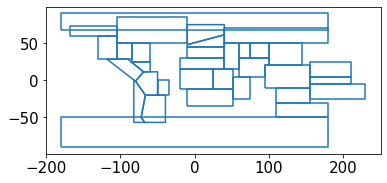

In [10]:
# ICPP reference regions 
import geopandas as gpd
geo_ref_reg = gpd.read_file(dir+'referenceRegions.shp')
geo_ref_reg.boundary.plot()


In [11]:
# Cluster files 
cluster=xr.open_mfdataset(dir+'clustering_kmeans_fireSeason_5c.nc')

In [12]:
cluster = cluster.sel(time=('1981-01-01'),drop=True)
dfclu=cluster.to_dataframe().reset_index()

clusters=[0,1,2,3,4,5]
dfclu_by_group=dfclu.groupby(pd.cut(dfclu["fwinx"],clusters))
dfclu_by_group

In [13]:
my_cmap = (colors.ListedColormap(hex_list))

norm = colors.BoundaryNorm(clusters, my_cmap.N)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


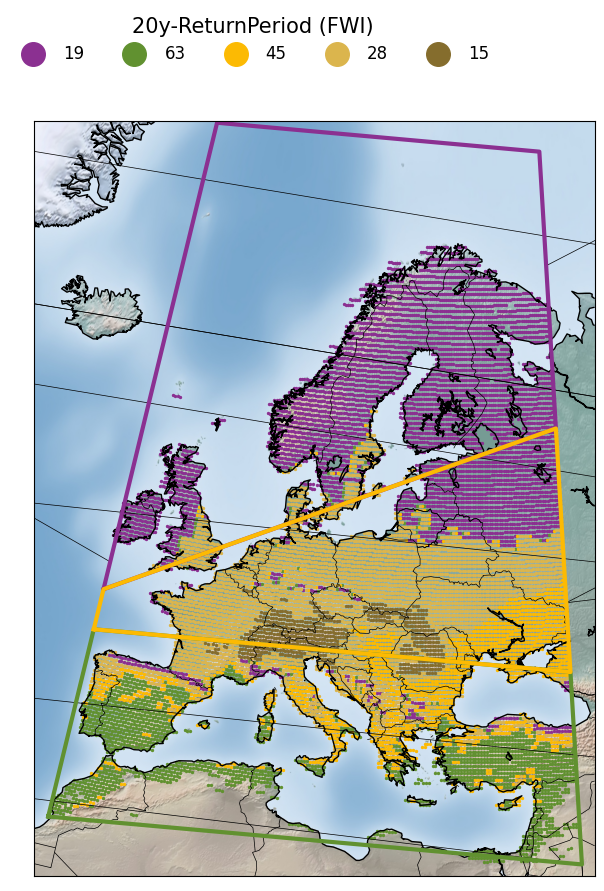

In [15]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(111)
#ax = fig.add_axes([0.1,0.1,0.8,0.8])
# setup of basemap ('lcc' = lambert conformal conic).
# use major and minor sphere radii from WGS84 ellipsoid.
m = Basemap(llcrnrlon=-10,llcrnrlat=25.,urcrnrlon=49,urcrnrlat=76,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',area_thresh=1000.,projection='lcc',\
            lat_1=20.,lon_0=30.,ax=ax)
# transform to nx x ny regularly spaced 5km native projection grid
#nx = int((m.xmax-m.xmin)/5000.)+1; ny = int((m.ymax-m.ymin)/5000.)+1

# draw coastlines and political boundaries.
m.drawcoastlines()
m.drawcountries()
m.drawstates()
# draw parallels and meridians.
# label on left and bottom of map.
parallels = np.arange(0.,80,20.)
#m.drawparallels(parallels,labels=[1,0,0,1])
meridians = np.arange(10.,360.,30.)
#m.drawmeridians(meridians,labels=[1,0,0,1])
#m.bluemarble()
m.shadedrelief()
# add colorbar
#cb = m.colorbar(im,"right", size="5%", pad='2%')

my_cmap = colors.ListedColormap(hex_list)

# Specify the number of discrete levels to use in the colormap


alpha=[0.4,0.6,0.8,1,1,1]

seq=0

hex_list =['#f5efc6','#619130','#fcba03','#d4170d','#8b3091']
#white,green,yellow,red,purple

cust_hex=['#8b3091','#619130','#fcba03','#dbb54d','#856d2d']
alpha=[1,1,1,1,1]
# return period have been calculated somewhere else 
return_period=[19,63,45,28,15]
for group_name, df_group in dfclu_by_group :
    # This is very important ! you need to calulate the p
    x, y = m(df_group['lon'], df_group['lat'])
    ax=m.scatter(
    x=x, 
    y=y, 
    s=2, 
    alpha=alpha[seq],
    c=cust_hex[seq],
    norm=norm,
    label=return_period[seq]     )
    seq=seq+1
#ax here is an artist not an axis we need to import it as an axis
ax = plt.gca()    
m.readshapefile(dir+'referenceRegions', 'ipcc_reg')
for info, shape in zip(m.ipcc_reg_info, m.ipcc_reg):
    if info['LAB'] == 'NEU':
        x, y = zip(*shape) 
        m.plot(x, y, marker=None,color='#8b3091',linewidth=3., zorder=2)
    if info['LAB'] == 'CEU':
        x, y = zip(*shape) 
        m.plot(x, y, marker=None,color='#fcba03',linewidth=3., zorder=100)
    if info['LAB'] == 'MED':
        x, y = zip(*shape) 
        m.plot(x, y, marker=None,color='#619130',linewidth=3., zorder=2)


plt.legend(loc='upper left',prop={'size': 12} ,ncol=6,
    bbox_to_anchor=(0.2, 1), frameon=False, 
    title_fontsize=15, markerscale=12,
    title='20y-ReturnPeriod (FWI)',
    bbox_transform=fig.transFigure)

fig.savefig('/home/nen/Python/images/IPCC_cluster_region_th.eps')
plt.show()

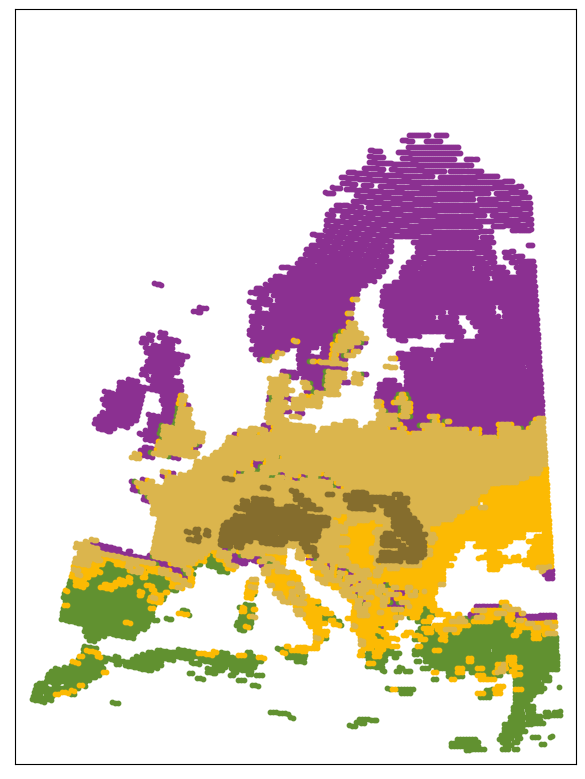

In [17]:
# map for the surface responce cirve plots (Figure 2 and 3 )
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(111)
#ax = fig.add_axes([0.1,0.1,0.8,0.8])
# setup of basemap ('lcc' = lambert conformal conic).
# use major and minor sphere radii from WGS84 ellipsoid.
m = Basemap(llcrnrlon=-10,llcrnrlat=25.,urcrnrlon=49,urcrnrlat=76,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',area_thresh=1000.,projection='lcc',\
            lat_1=20.,lon_0=30.,ax=ax)
# transform to nx x ny regularly spaced 5km native projection grid
#nx = int((m.xmax-m.xmin)/5000.)+1; ny = int((m.ymax-m.ymin)/5000.)+1

# draw coastlines and political boundaries.

# draw parallels and meridians.
# label on left and bottom of map.
parallels = np.arange(0.,80,20.)
#m.drawparallels(parallels,labels=[1,0,0,1])
meridians = np.arange(10.,360.,30.)


my_cmap = colors.ListedColormap(hex_list)

# Specify the number of discrete levels to use in the colormap


alpha=[0.4,0.6,0.8,1,1,1]

seq=0

hex_list =['#f5efc6','#619130','#fcba03','#d4170d','#8b3091']
#white,green,yellow,red,purple

cust_hex=['#8b3091','#619130','#fcba03','#dbb54d','#856d2d']
alpha=[1,1,1,1,1]
return_period=[19,63,45,28,15]
for group_name, df_group in dfclu_by_group :

    # This is very important ! you need to calulate the p
    x, y = m(df_group['lon'], df_group['lat'])
    ax=m.scatter(
    x=x, 
    y=y, 
    s=10, 
    alpha=alpha[seq],
    c=cust_hex[seq],
    norm=norm,
    label=return_period[seq]     )
    seq=seq+1
#ax here is an artist not an axis we need to import it as an axis
ax = plt.gca()    


fig.savefig('/home/nen/Python/images/IPCC_cluster_region_shaded.eps')
plt.show()

In [ ]:
# Mid term projection
file_st='EUpoints_pbExceedance_20yrp_meanClimateProjections.nc'
file_lt='EUpoints_pbExceedance_20yrp_mean_long_termClimateProjections.nc'
file_st='EUpoints_nbDays_half20yrp_mean_mid_term_ClimateProjections_new.nc'
file_lt='EUpoints_nbDays_half20yrp_mean_long_term_ClimateProjections_new.nc'
file=file_lt
spot = xr.open_mfdataset(dir+file)


In [ ]:
spot

In [ ]:
spot = spot.sel(time=('1981-01-01'),drop=True)
df=spot.to_dataframe().reset_index()
#df[df['fwinx']>80] =5


In [ ]:
#steps=[5,10,15,20,25,50] #for prob of exceedence
steps=[0,4,8,12,16,22] # for days in a season 
df1=df.groupby(pd.cut(df["fwinx"], steps))
groups = dict(list(df1))
groups.keys()

In [ ]:
df1

In [ ]:
my_regions={'a) Boreal-NEU':[15,40,63,71],
            'b) West-Med':[9,20,41,47],
            'c) Southern France':[3,8,43,46],
            'd) Atlantic CEU':[3,8,50,54],
            'e) Iberia':[-10,2,36,43.5],
            'f) East-Med':[12,25,36,40],
            'g) Eastern Turkey':[31,40,36,41],
     }
nr=len(my_regions)
patches = []

for key in my_regions:
    print(key)
    lon1=my_regions[key][0]
    lon2=my_regions[key][1]
    lat1=my_regions[key][2]
    lat2=my_regions[key][3]
    pol = np.array([[lon1,lat1],[lon1,lat2],[lon2,lat2],[lon2,lat1]])
    patches.append(Polygon(pol))
    
    
#check the patches
# Make the figure
fig = plt.figure()
ax = fig.add_subplot(111)

m = Basemap(projection='cyl',llcrnrlat=30,urcrnrlat=75,\
            llcrnrlon=-15,urcrnrlon=40,resolution='c')
m.drawcoastlines()
#m.fillcontinents()
# draw parallels and meridians.

m.drawmapboundary()

# Fill two polygon shapes
patches = []

for key in my_regions:
    print(key)
    lon1=my_regions[key][0]
    lon2=my_regions[key][1]
    lat1=my_regions[key][2]
    lat2=my_regions[key][3]
    pol = np.array([[lon1,lat1],[lon1,lat2],[lon2,lat2],[lon2,lat1]])
    patches.append(Polygon(pol))

ax.add_collection(PatchCollection(patches, facecolor='tab:green', alpha=0.6,edgecolor='k', linewidths=3))

plt.show()

In [ ]:
# create the figure and axes instances.
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(111)
#ax = fig.add_axes([0.1,0.1,0.8,0.8])
# setup of basemap ('lcc' = lambert conformal conic).
# use major and minor sphere radii from WGS84 ellipsoid.
#m = Basemap(llcrnrlon=-15,llcrnrlat=30.,urcrnrlon=40,urcrnrlat=70,\
#            rsphere=(6378137.00,6356752.3142),\
#            resolution='l',area_thresh=1000.,projection='lcc',\
#            lat_1=20.,lon_0=30.,ax=ax)
m = Basemap(llcrnrlon=-10,llcrnrlat=25.,urcrnrlon=49,urcrnrlat=76,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',area_thresh=1000.,projection='lcc',\
            lat_1=20.,lon_0=30.,ax=ax)

# transform to nx x ny regularly spaced 5km native projection grid
#nx = int((m.xmax-m.xmin)/5000.)+1; ny = int((m.ymax-m.ymin)/5000.)+1

# draw coastlines and political boundaries.
m.drawcoastlines()
m.drawcountries()
m.drawstates()
# draw parallels and meridians.
# label on left and bottom of map.
parallels = np.arange(0.,80,20.)
m.drawparallels(parallels,labels=[1,0,0,1])
meridians = np.arange(10.,360.,30.)
m.drawmeridians(meridians,labels=[1,0,0,1])
#m.bluemarble()
m.shadedrelief()
# add colorbar
#cb = m.colorbar(im,"right", size="5%", pad='2%')

my_cmap = colors.ListedColormap(hex_list)

# Specify the number of discrete levels to use in the colormap

alpha=[0.4,0.6,0.8,1,1,1]

seq=0

for group_name, df_group in df1:
   # print(group_name)
   # print(df_group)
    # This is very important ! you need to calulate the p
    x, y = m(df_group['lon'], df_group['lat'])
    ax=m.scatter(
    x=x, 
    y=y, 
    s=5, 
    alpha=alpha[seq],
    c=hex_list[seq],
    norm=norm,
    label=group_name     )
    seq=seq+1
#ax here is an artist not an axis we need to import it as an axis

ax = plt.gca()    
# Fill two polygon shapes
patches = []

#for key in my_regions:
#    print(key)
#    lon1=my_regions[key][0]
#    lon2=my_regions[key][1]
#    lat1=my_regions[key][2]
#    lat2=my_regions[key][3]
#    lower_left=m(lon1,lat1)
#    lower_right=m(lon2,lat1)
#    upper_left=m(lon1,lat2)
#    upper_right=m(lon2,lat2)
#    pol = np.array([lower_left,lower_right,upper_right,upper_left])
#    patches.append(Polygon(pol))

#ax.add_collection(PatchCollection(patches, facecolor='None', alpha=0.8,edgecolor='k', linewidths=2))

plt.legend(loc='upper left',prop={'size': 12} ,ncol=6,
    bbox_to_anchor=(0.1, 1.0), frameon=False,
    title_fontsize=15,markerscale=6,
    title='Probability of a 20year return period event \n',
    bbox_transform=fig.transFigure)

plt.savefig('/home/nen/Python/images/'+file+'.eps',dpi=600)
plt.show()


Groupped by clusters 

In [ ]:
my_cluster={'Boreal':1,
            'Temperate':4,
            'Alpine':5,
            'Semi-Arid':3,
            'Med':2
     }

In [ ]:
category_names = ['5-10%', '10-15%','15-20%', '20-25%', '25-50%']
cluster_dict={}
spot = xr.open_mfdataset(dir+file)  
spot = spot.sel(time=('1981-01-01'),drop=True)
df=spot.to_dataframe().reset_index()

df.rename(columns = {'fwinx':'prob'}, inplace = True)
dfclu.rename(columns = {'fwinx':'cluster'}, inplace = True)
#dfroi=roi.to_dataframe().reset_index()
df['cluster']=dfclu.cluster

for key in my_cluster:
    print(key)
    idc=my_cluster[key]
    print(idc)
    roi=df.loc[df['cluster'] == idc]
    print(roi)
    roi_grouped=roi.groupby(pd.cut(roi["prob"], steps)).count()
    all_val=sum(roi_grouped.prob.values)
    print(all_val)
    cluster_dict[key]=list(roi_grouped.prob.values/all_val*100)
    
cluster_dict

Grupped by hot spot

In [ ]:
category_names = ['5-10%', '10-15%','15-20%', '20-25%', '25-50%']

mydict={}
explode=(0.05,0.05,0.05,0.05,0.05) 
seq=0
for key in my_regions:
    print(key)
    lon1=my_regions[key][0]
    lon2=my_regions[key][1]
    lat1=my_regions[key][2]
    lat2=my_regions[key][3]
    spot = xr.open_mfdataset(dir+file)  
    roi=spot.sel(lon=slice(lon1,lon2),lat=slice(lat2,lat1),time=('1981-01-01'),drop=True)
    dfroi=roi.to_dataframe().reset_index()
  #  dfroi[dfroi['fwinx']>80] =5
   # print(dfroi)
#    fig, ax = plt.subplots(1)
    df_grouped=dfroi.groupby(pd.cut(dfroi["fwinx"], steps)).count()
    all_val=sum(df_grouped.fwinx.values)
    print(all_val)
    mydict[key]=list(df_grouped.fwinx.values/all_val*100)
   # print(mydict)
  

In [ ]:
results=mydict    
def survey(results, category_names):
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))
    print(category_colors)
    print(hex_list)

    fig, ax = plt.subplots(figsize=(11, 5),dpi=300)
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())
    for i, (colname, color) in enumerate(zip(category_names, hex_list)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                label=colname, color=color)
        xcenters = starts + widths / 2
       # r, g, b, _ = color
        text_color = 'k'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            print(c)
            ax.text(x, y, str(math.ceil(c)), ha='center', va='center',
                    color=text_color, fontsize=11)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='medium')
    ax.spines['top'].set_visible(False)    

    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
  
    return fig, ax

survey(mydict,category_names)
plt.savefig('/home/nen/Python/images/'+file+'_bars.eps',dpi=600)
plt.show()


In [ ]:
survey(cluster_dict,category_names)
plt.savefig('/home/nen/Python/images/'+file+'cluster_bars.eps',dpi=600)
plt.show()

Pie Charts instead 

In [ ]:
# create the figure and axes instances.#

mydict={}
explode=(0.05,0.05,0.05,0.05,0.05) 
seq=0
for key in my_regions:
    print(key)
    lon1=my_regions[key][0]
    lon2=my_regions[key][1]
    lat1=my_regions[key][2]
    lat2=my_regions[key][3]
    spot = xr.open_mfdataset(dir+'EUpoints_pbExceedance_20yrp_meanClimateProjections.nc')  
    roi=spot.sel(lon=slice(lon1,lon2),lat=slice(lat2,lat1),time=('1981-01-01'),drop=True)
    dfroi=roi.to_dataframe().reset_index()
    dfroi[dfroi['fwinx']>80] =5
    dfroi
#    fig, ax = plt.subplots(1)
    a=dfroi.groupby(pd.cut(dfroi["fwinx"], steps)).count()
    a1=a.fwinx.values
    mydict[key]=list(a1)
    print(mydict)
    print(a.fwinx.values)
    ax=dfroi.groupby(pd.cut(dfroi["fwinx"], steps)).sum().plot(kind='pie', y='fwinx', 
        autopct='%1.0f%%',title=key,colors=hex_list,explode=explode,legend=False)   
    fig = ax.get_figure()
    fig.savefig('/home/nen/scripts/python3/'+key+'.eps')
 

In [ ]:
mydict